## Task 1: PINNS for solving PDE

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import time

torch.autograd.set_detect_anomaly(True)


In [26]:
#Reusing the class NeuralNet as given in the tutorail
class NeuralNet(nn.Module):
    """
    This class implements a simple feedforward neural network with a variable number of hidden layers (taken from tutorial)
    """

    def __init__(
        self, input_dimension, output_dimension, n_hidden_layers, neurons, retrain_seed
    ):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)]
        )
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain("tanh")
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

In [27]:
## Adapting the class pin to our problem
class Pinns:
    """
    This class implements the solution of the heat equation with a source term using PINNs

    Parameters
    ----------
    n_int_ : int
        Number of interior points
    n_sb_ : int
        Number of spatial boundary points
    n_tb_ : int
        Number of temporal boundary points
    T_0 : float
        Initial temperature
    T_hot : float
        Hot temperature
    alpha_f : float
        Diffusion coefficient of the fluid
    alpha_s : float
        Diffusion coefficient of the solid
    h_f : float 
        Heat transfer coefficient of the fluid
    h_s : float
        Heat transfer coefficient of the solid
    U_f : float
        Fluid velocity  
    
    
    Attributes
    ----------
    (same as parameters)

    domain_extrema : torch.tensor
        Extrema of the solution domain (t,x) in [0,1]x[0,1]
    space_dimensions : int
        Number of space dimensions
    lambda_u : float
        Parameter to balance role of data and PDE
    approximate_solution : NeuralNet
        F Dense NN to approximate the solution of the set of differential equations
    soboleng : torch.quasirandom.SobolEngine
        Generator of Sobol sequences
    training_set_sb_D : torch.utils.data.DataLoader
        Training set S_sb for Dirichlet boundary condition
    training_set_sb_VN_0 : torch.utils.data.DataLoader  
        Training set S_sb for Von Neuman boundary condition at x=0
    training_set_sb_VN_L : torch.utils.data.DataLoader
        Training set S_sb for Von Neuman boundary condition at x=L
    training_set_tb : torch.utils.data.DataLoader   
        Training set S_tb for temporal boundary condition
    training_set_int : torch.utils.data.DataLoader
        Training set S_int for interior points

    Methods
    -------
    convert(tens)
        Linearly transform a tensor whose value are between 0 and 1 to a tensor whose values are between the domain extrema 
    add_temporal_boundary_points()
        Return the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    add_spatial_boundary_points_Dirichlet()
        Return the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary for Dirichlet
    add_spatial_boundary_points_VN()    
        Return the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary for Von Neuman
    add_interior_points()
        Return the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    assemble_datasets()
        Return the training sets S_sb, S_tb, S_int as dataloader
    apply_initial_condition(input_tb)
        Compute the terms required in the definition of the TEMPORAL boundary residual
    apply_boundary_conditions_D(input_sb)
        Compute the terms required in the definition of the SPATIAL boundary residual for Dirichlet
    apply_boundary_conditions_VN_0(input_sb)
        Compute the terms required in the definition of the SPATIAL boundary residual for Von Neuman at x=0
    apply_boundary_conditions_VN_L(input_sb)
        Compute the terms required in the definition of the SPATIAL boundary residual for Von Neuman at x=L
    compute_pde_residual(input_int)
        Compute the PDE residuals
    compute_loss(inp_train_sb_D, T_train_sb_D, inp_train_sb_VN_0, T_train_sb_VN_0, inp_train_sb_VN_L, T_train_sb_VN_L, inp_train_tb, u_train_tb, inp_train_int, verbose=True)
        Compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    fit(num_epochs, optimizer, verbose=True)
        Fit the model
    plotting(n_points = 100000)
        Plot the approximate solution of the PDE, both for Tf and Ts

    """
    def __init__(self, n_int_, n_sb_, n_tb_, T_0, T_hot, alpha_f, alpha_s, h_f, h_s, U_f):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_
        self.T_0 = T_0
        self.T_hot = T_hot
        self.alpha_f = alpha_f
        self.alpha_s = alpha_s
        self.h_f = h_f
        self.h_s = h_s
        self.U_f = U_f

        # Extrema of the solution domain (t,x) in [0,1]x[0,1]
        self.domain_extrema = torch.tensor(
            [[0, 1], [0, 1]]  # Time dimension
        )  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 100

        # F Dense NN to approximate the solution of the set of differential equations
        # I decided to use a double output of my PINN, the first output will be the value
        # of Tf the second will be the value of Ts
        self.approximate_solution = NeuralNet(
            input_dimension=self.domain_extrema.shape[0],
            output_dimension=2,
            n_hidden_layers=5,
            neurons=20,
            retrain_seed=42,
        )

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(
            dimension=self.domain_extrema.shape[0]
        )

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb_D, self.training_set_sb_VN_0, self.training_set_sb_VN_L, self.training_set_tb, self.training_set_int = (
            self.assemble_datasets()
        )

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    # SHOULDN'T be really neaded in this case, but because was in the original code I kept it
    def convert(self, tens):
        assert tens.shape[1] == self.domain_extrema.shape[0]
        return (
            tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0])
            + self.domain_extrema[:, 0]
        )


    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = torch.full(input_tb[:, 0].shape, self.T_0)

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points_Dirichlet(self):
        x0 = self.domain_extrema[1, 0]

        # Not really needed as domain already in [0,1]
        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        output_sb_0 = (self.T_hot - self.T_0) / (1 + np.exp( -200 * (input_sb_0[:,0] - 0.25))) + self.T_0

        return  input_sb_0, output_sb_0

    def add_spatial_boundary_points_VN(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        # Not really needed as domain already in [0,1]
        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = torch.full(input_sb_0[:, 1].shape, 0)
        output_sb_L = torch.full(input_sb_L[:, 1].shape, 0)


        return input_sb_0, input_sb_L, output_sb_0, output_sb_L 

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb_D, output_sb_D = self.add_spatial_boundary_points_Dirichlet()  # S_sb for dirichlet 
        input_sb_VN_0, input_sb_VN_L, output_sb_VN_0, output_sb_VN_L = self.add_spatial_boundary_points_VN()   # S_sb for Von Neuman 
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()  # S_int

        training_set_sb_D= DataLoader(
            torch.utils.data.TensorDataset(input_sb_D, output_sb_D),
            batch_size= 2 * self.space_dimensions * self.n_sb,
            shuffle=False,
        )
        training_set_sb_VN_0 = DataLoader(
            torch.utils.data.TensorDataset(input_sb_VN_0, output_sb_VN_0),
            batch_size=2 * self.space_dimensions * self.n_sb,
            shuffle=False,
        )
        training_set_sb_VN_L = DataLoader(
            torch.utils.data.TensorDataset(input_sb_VN_L, output_sb_VN_L),
            batch_size=2 * self.space_dimensions * self.n_sb,
            shuffle=False,
        )

        training_set_tb = DataLoader(
            torch.utils.data.TensorDataset(input_tb, output_tb),
            batch_size=self.n_tb,
            shuffle=False,
        )
        training_set_int = DataLoader(
            torch.utils.data.TensorDataset(input_int, output_int),
            batch_size=self.n_int,
            shuffle=False,
        )

        return (
            training_set_sb_D,
            training_set_sb_VN_0,
            training_set_sb_VN_L,
            training_set_tb,
            training_set_int,
        )

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        Tf_pred_tb = self.approximate_solution(input_tb)[:,0]
        Ts_pred_tb = self.approximate_solution(input_tb)[:,1]
        return Tf_pred_tb, Ts_pred_tb

    # Functions to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions_D(self, input_sb):
        Tf_pred_sb_D= self.approximate_solution(input_sb)[:,0]
        return Tf_pred_sb_D

    def apply_boundary_conditions_VN_0(self, input_sb):
        input_sb.requires_grad = True
        Ts_pred_sb_VN = self.approximate_solution(input_sb)[:,1]
        # calcualte the gradient of Ts wrt x
        grad_Ts_x = torch.autograd.grad(Ts_pred_sb_VN.sum(), input_sb, create_graph=True)[0][:, 1]

        return grad_Ts_x

    def apply_boundary_conditions_VN_L(self, input_sb):
        input_sb.requires_grad = True
        Tf_pred_sb_VN = self.approximate_solution(input_sb)[:,0]
        Ts_pred_sb_VN = self.approximate_solution(input_sb)[:,1]

        # calcualte the gradient of Ts and Tf wrt x
        grad_Tf_x = torch.autograd.grad(Tf_pred_sb_VN.sum(), input_sb, create_graph=True)[0][:, 1]
        grad_Ts_x = torch.autograd.grad(Ts_pred_sb_VN.sum(), input_sb, create_graph=True)[0][:, 1]

        return grad_Tf_x, grad_Ts_x

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        T = self.approximate_solution(input_int)

        grad_Tf = torch.autograd.grad(T[:,0].sum(), input_int, create_graph=True)[0]
        grad_Ts = torch.autograd.grad(T[:,1].sum(), input_int, create_graph=True)[0]

        grad_Tf_t = grad_Tf[:, 0]
        grad_Tf_x = grad_Tf[:, 1]
        grad_Tf_xx = torch.autograd.grad(grad_Tf_x.sum(), input_int, create_graph=True)[0][:, 1]

        grad_Ts_t = grad_Ts[:, 0]
        grad_Ts_x = grad_Ts[:, 1]
        grad_Ts_xx = torch.autograd.grad(grad_Ts_x.sum(), input_int, create_graph=True)[0][:, 1]

        residual_1 = grad_Tf_t + self.U_f * grad_Tf_x - self.alpha_f * grad_Tf_xx + self.h_f * (T[:,0] - T[:,1])
        residual_2 = grad_Ts_t - self.alpha_s * grad_Ts_xx - self.h_s * (T[:,0] - T[:,1])

        return residual_1, residual_2

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(
        self,
        inp_train_sb_D,
        T_train_sb_D,
        inp_train_sb_VN_0,
        T_train_sb_VN_0,
        inp_train_sb_VN_L,
        T_train_sb_VN_L,
        inp_train_tb,
        u_train_tb,
        inp_train_int,
        verbose=True,
    ):

        T_pred_sb_D = self.apply_boundary_conditions_D(inp_train_sb_D)
        T_pred_sb_VN_0 = self.apply_boundary_conditions_VN_0(inp_train_sb_VN_0)
        Tf_pred_sb_VN_L, Ts_pred_sb_VN_L = self.apply_boundary_conditions_VN_L(inp_train_sb_VN_L)
        Tf_pred_tb , Ts_pred_tb = self.apply_initial_condition(inp_train_tb)

        r_int_1, r_int_2 = self.compute_pde_residual(inp_train_int)

        r_sb_D = T_train_sb_D - T_pred_sb_D

        r_sb_VN_0 = T_train_sb_VN_0 - T_pred_sb_VN_0
        r_sb_VN_L_1 = T_train_sb_VN_L - Tf_pred_sb_VN_L
        r_sb_VN_L_2 = T_train_sb_VN_L - Ts_pred_sb_VN_L
        r_sb_VN = r_sb_VN_0 + r_sb_VN_L_1 + r_sb_VN_L_2

        r_tb_Tf = u_train_tb - Tf_pred_tb
        r_tb_Ts = u_train_tb - Ts_pred_tb
        r_tb = r_tb_Tf + r_tb_Ts

        loss_sb_D = torch.mean(abs(r_sb_D) ** 2)
        loss_sb_VN = torch.mean(abs(r_sb_VN) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int_1 = torch.mean(abs(r_int_1) ** 2)
        loss_int_2 = torch.mean(abs(r_int_2) ** 2)

        loss_u = loss_sb_D + loss_sb_VN + loss_tb
        loss_int = loss_int_1 + loss_int_2

        loss = torch.log10(self.lambda_u * (loss_sb_D + loss_sb_VN + loss_tb) + loss_int)
        if verbose:
            print(
                "Total loss: ",
                round(loss.item(), 4),
                "| PDE Loss: ",
                round(torch.log10(loss_u).item(), 4),
                "| Function Loss: ",
                round(torch.log10(loss_int).item(), 4),
            )

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose:
                print(
                    "################################ ",
                    epoch,
                    " ################################",
                )

            for j, (
                (inp_train_sb_D, T_train_sb_D),
                (inp_train_sb_VN_0, T_train_sb_VN_0),
                (inp_train_sb_VN_L, T_train_sb_VN_L),
                (inp_train_tb, T_train_tb),
                (inp_train_int, T_train_int),
            ) in enumerate(
                zip(
                    self.training_set_sb_D,
                    self.training_set_sb_VN_0,
                    self.training_set_sb_VN_L,
                    self.training_set_tb,
                    self.training_set_int,
                )
            ):

                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(
                        inp_train_sb_D,
                        T_train_sb_D,
                        inp_train_sb_VN_0, 
                        T_train_sb_VN_0,
                        inp_train_sb_VN_L,
                        T_train_sb_VN_L,
                        inp_train_tb,
                        T_train_tb,
                        inp_train_int,
                        verbose=verbose,
                    )
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print("Final Loss: ", history[-1])

        return history

    ################################################################################################

    def plotting(self, n_points = 100000):
        """
        Function to plot the approximate solution of the PDE, both for Tf and Ts
        """

        inputs = self.convert(self.soboleng.draw(n_points))

        output = self.approximate_solution(inputs)
        output_Tf = output[:, 0].reshape(
            -1,
        )
        output_Ts = output[:, 1].reshape(
            -1,
        )

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(
            inputs[:, 1].detach(), inputs[:, 0].detach(), c=output_Tf.detach(), cmap="jet"
        )
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(
            inputs[:, 1].detach(), inputs[:, 0].detach(), c=output_Ts.detach(), cmap="jet"
        )
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Approximate Solution $T_f$")
        axs[1].set_title("Approximate Solution $T_s$")

        plt.show()

In [28]:
# Parameters
n_int = 256
n_sb = 64
n_tb = 64
T_0 = 1
T_hot = 4
alpha_f = 0.05
alpha_s = 0.08
h_f = 5
h_s = 6
U_f = 1

# Create the PINN
pinn = Pinns(n_int, n_sb, n_tb, T_0, T_hot, alpha_f, alpha_s, h_f, h_s, U_f)

In [29]:
# Training parameters

n_epochs = 2000
optimizer_LBFGS = optim.LBFGS(
    pinn.approximate_solution.parameters(),
    lr=float(0.5),
    max_iter=50000,
    max_eval=50000,
    history_size=150,
    line_search_fn="strong_wolfe",
    tolerance_change=1.0 * np.finfo(float).eps,
)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(), lr=float(0.001))

################################  0  ################################
Total loss:  3.1681 | PDE Loss:  1.1384 | Function Loss:  1.9873
################################  1  ################################
Total loss:  3.0945 | PDE Loss:  1.0527 | Function Loss:  2.0573
################################  2  ################################
Total loss:  3.0257 | PDE Loss:  0.9683 | Function Loss:  2.1186
################################  3  ################################
Total loss:  2.9631 | PDE Loss:  0.8865 | Function Loss:  2.172
################################  4  ################################
Total loss:  2.9072 | PDE Loss:  0.8081 | Function Loss:  2.2168
################################  5  ################################
Total loss:  2.8569 | PDE Loss:  0.7332 | Function Loss:  2.2513
################################  6  ################################
Total loss:  2.8107 | PDE Loss:  0.6616 | Function Loss:  2.2742
################################  7  ###################

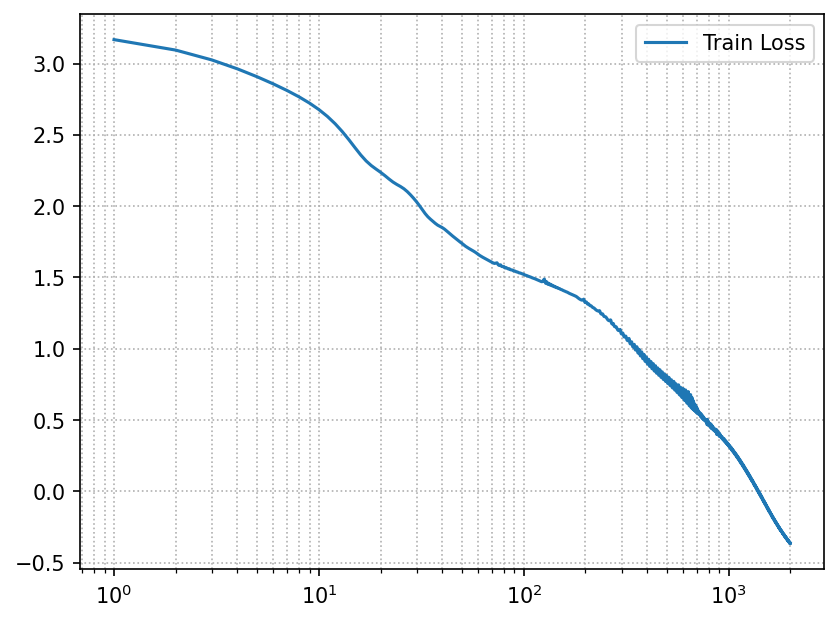

In [30]:
# Training
hist = pinn.fit(num_epochs=n_epochs, optimizer=optimizer_ADAM, verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

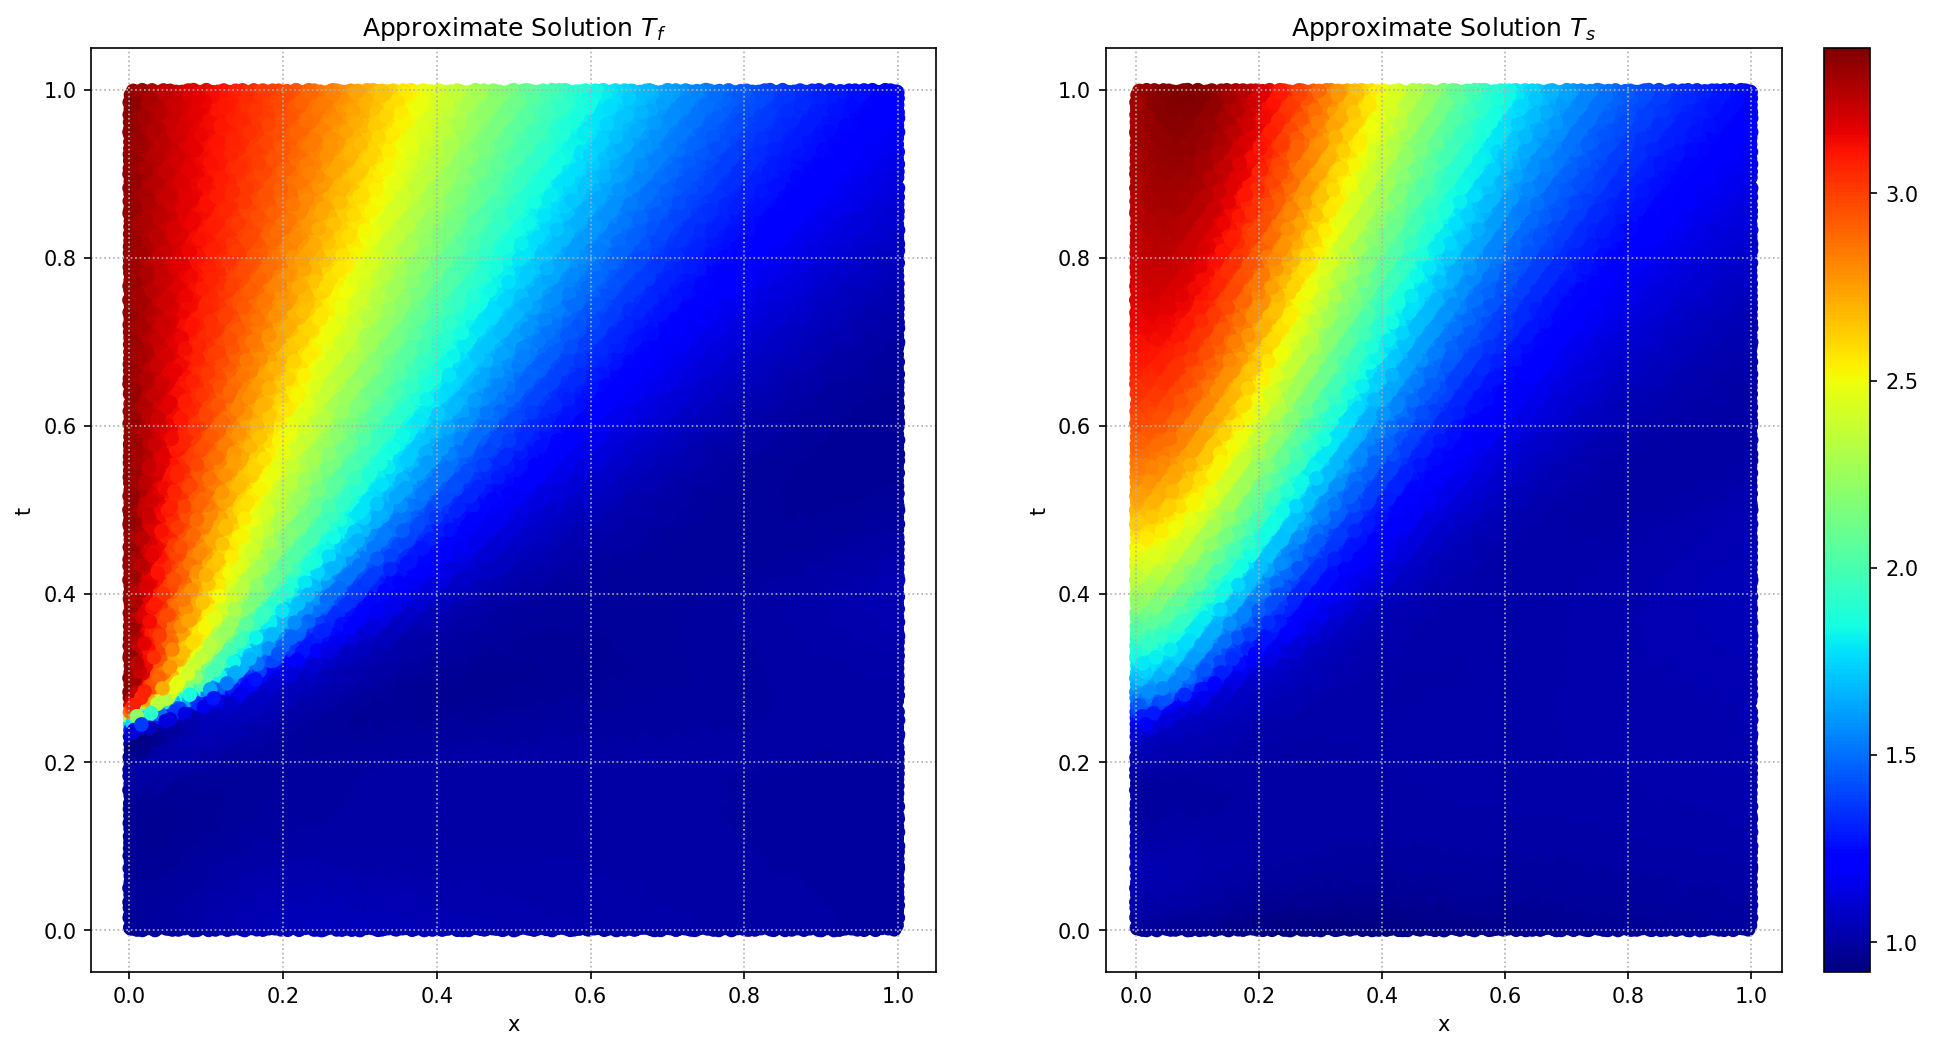

In [33]:
# Plotting the solution
pinn.plotting(n_points=70000)

In [39]:
#Here I read the data from the .txt file and return them as a torch tensor ignoring the first row which contains the headers
#there are two columns which are comma separed

def read_data(file_name):
    data = np.loadtxt(file_name, delimiter=",", skiprows=1)
    return torch.tensor(data, dtype=torch.float32)

test_data = read_data(
    "/Users/lorenzotarricone/Desktop/ETH/2nd_semester/AI in Science and Engineering /Proj1_Y24/Task1/TestingData.txt"
)

#get values for Tf and Ts from the trained pinn
def get_values(test_data):
    output = pinn.approximate_solution(test_data)
    output_Tf = output[:, 0].reshape(-1, )
    output_Ts = output[:, 1].reshape(-1, )
    return output_Tf, output_Ts

test_data_Tf, test_data_Ts = get_values(test_data)

#save the results in a .txt file with the same format as the input file
#the first row contains the headers t, x, tf, ts
#the following rows contain the values of t, x, tf, ts

def save_results(file_name, test_data, test_data_Tf, test_data_Ts):
    with open(file_name, "w") as f:
        f.write("t,x,tf,ts\n")
        for i in range(len(test_data)):
            f.write(
                f"{test_data[i][0]},{test_data[i][1]},{test_data_Tf[i]},{test_data_Ts[i]}\n"
            )

save_results(
    "/Users/lorenzotarricone/Desktop/ETH/2nd_semester/AI in Science and Engineering /Proj1_Y24/Task1/Lorenzo_Tarricone_23946502.txt",
    test_data,
    test_data_Tf,
    test_data_Ts,
)